# Papier, kamień, nożyce
Autorka: Małgorzata Rucka

Zadanie polegało na stworzeniu datasetu na podstawie obrazów przedstawiających pojedyncze ręce w grze papier, kamień, nożyce który wygląda jak dwie osoby grające w grę wraz z ich labelami. Zaprojektowałam to w postaci zwracającego takie zdjęcie z labelem w postaci one hot. Ostatecznie z powodu przypadkowości wybieranych zdjęć, końcowy wynik modelu różnił się trochę za każdym razem po wytrenowaniu modelu. 

In [1]:
import os
import random
import cv2
import keras
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics
from zipfile import ZipFile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

 
def decode_labels(label1, label2):
    mlb = MultiLabelBinarizer(classes=[('paper'), ('rock'), ('scissors')])
    return mlb.fit_transform([(label1, label2)])

def one_hot_to_string(vect):
  labels = ''
  if sum(sum(vect)) == 1:
    if vect[0] == 1:
      labels += 'paper + paper'
    elif vect[1] == 1:
      labels += 'rock + rock'
    elif vect[2] == 1:
      labels += 'scissors + scissors'
  else:
    if vect[0] == 1:
      labels += 'paper +'
    if vect[1] == 1 and not labels:
      labels += 'rock +'
    elif vect[1] == 1:
      labels += 'rock'
    if vect[2] == 1:
      labels += 'scissors'
  return labels

def get_data(filepath='drive/MyDrive/rps', batch_size=16):
    labels = ['paper', 'rock', 'scissors']
    while True:
 
        X, y = [], []
        for i in range(batch_size):
            label1 = random.choice(labels)
            label2 = random.choice(labels)
            filename1 = random.choice(os.listdir(os.path.join(filepath, label1)))
            filename2 = random.choice(os.listdir(os.path.join(filepath, label2)))
            path1 = os.path.join(filepath, label1, filename1)
            path2 = os.path.join(filepath, label2, filename2)
            img_right = Image.open(path1).rotate(90).resize([50,50])
            img_left = Image.open(path2).rotate(-90).resize([50,50])
            image = cv2.hconcat([np.array(img_left)/255, np.array(img_right)/255])
 
            label_out = decode_labels(label1, label2)
            X.append(image)
            y.append(label_out[0])
        yield np.array(X), np.array(y)
 
 
def get_model(n_outputs):
    model = Sequential([
        Conv2D(16, (5, 5), activation='relu', input_shape=(50, 100, 4)),
        MaxPooling2D(2, 2),
        Dropout(0.05),
        Conv2D(32, (5, 5), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.05),
        Conv2D(64, (5, 5), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.05),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(n_outputs, activation='sigmoid')
    ])
    model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer='adam', metrics=['accuracy'] )
    return model
 
'''if not os.path.exists("rps-test-set.zip"):
    wget.download('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip')
    with ZipFile('rps-test-set.zip', 'r') as zipObj:
        zipObj.extractall()
if not os.path.exists("rps.zip"):
    wget.download('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip')
    with ZipFile('rps.zip', 'r') as zipObj:
        zipObj.extractall()'''


'if not os.path.exists("rps-test-set.zip"):\n    wget.download(\'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip\')\n    with ZipFile(\'rps-test-set.zip\', \'r\') as zipObj:\n        zipObj.extractall()\nif not os.path.exists("rps.zip"):\n    wget.download(\'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip\')\n    with ZipFile(\'rps.zip\', \'r\') as zipObj:\n        zipObj.extractall()'

Niestety accuracy w trakcie trenowania nie pokrywa się z prawdziwym accuracy - sprawdzam je na koniec

In [6]:
cp_callbacks = tensorflow.keras.callbacks.ModelCheckpoint(filepath = 'drive/MyDrive/model10', save_weights_only = True, verbose = 1)
es_callbacks = tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 4)

model = get_model(3)
model.summary()
H = model.fit(x=get_data(),epochs=8, steps_per_epoch = 70, validation_data = get_data(filepath = 'drive/MyDrive/rps-test-set'), validation_steps = 70, callbacks = [cp_callbacks, es_callbacks])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 96, 16)        1616      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 48, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 23, 48, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 44, 32)        12832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 9, 22, 32)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 9, 22, 32)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 18, 64)        

In [17]:
Xtest, ytest= next(get_data(filepath = 'drive/MyDrive/rps-test-set', batch_size = 1000))
perfomance_y =  model.predict(Xtest)
print('Accuracy na zbiorze walidacyjnym:',metrics.accuracy_score(ytest, (perfomance_y>0.5).astype('uint8')))
Xtest, ytest= next(get_data(filepath = 'drive/MyDrive/rps', batch_size = 1000))
perfomance_y =  model.predict(Xtest)
print('Accuracy na zbiorze treningowym:',metrics.accuracy_score(ytest, (perfomance_y>0.5).astype('uint8')))

Accuracy na zbiorze walidacyjnym: 0.801
Accuracy na zbiorze treningowym: 0.993


[[0 1 1]]
[[0 1 1]]


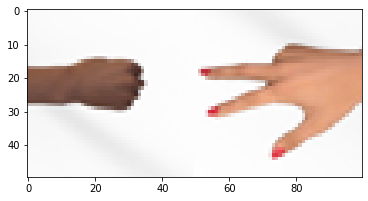

In [13]:
Xtest, ytest= next(get_data(filepath = 'drive/MyDrive/rps-test-set', batch_size = 1))
prediction = model.predict(Xtest)
print((prediction>0.5).astype('uint8'))
print((ytest))
plt.imshow(Xtest[0,:,:,:])
plt.show()

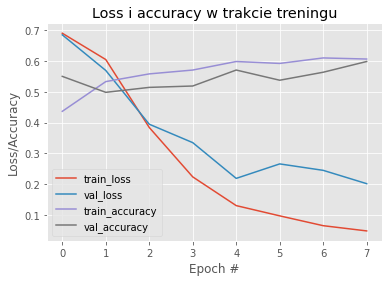

In [27]:
plt.style.use('ggplot')
plt.figure()
N = 8
plt.plot(np.arange(0,N), H.history['loss'], label = 'train_loss')
plt.plot(np.arange(0,N), H.history['val_loss'], label = 'val_loss')
plt.plot(np.arange(0,N), H.history['accuracy'], label = 'train_accuracy')
plt.plot(np.arange(0,N), H.history['val_accuracy'], label = 'val_accuracy')
plt.title('Loss i accuracy w trakcie treningu')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend(loc = 'lower left')
plt.show()

Ostateczne accuracy na zbiorze walidacyjnym to około 78-80%. Możemy zauważyć duży overfitting, który według mnie był nieunikniony biorąc pod uwagę jak wygląda zbiór walidycyjny - nie posiadamy 3000 zdjęć różnych rąk, lecz kilkadziesiąt rąk pod różnym kątem. Moim zdaniem warty spróbowania byłby transfer learning na sieci poprzednio wytrenowanej na zdjęciach rąk, ale niestety z powodu braku czasu nie udało się tego przetestować.